In [ ]:
import json 
import logging
import copy
import sys
import ast
import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager

# Dynamically get the backend path relative to the notebook location
notebook_path = Path().resolve()
project_root = notebook_path.parents[1]  # Go up to project root (adjust if needed)
sys.path.insert(0, str(project_root))
local_path = project_root / 'back_end'
sys.path.insert(0, str(local_path))

from src.utils.utils import *
from src.utils.logging_utils import *
from main import *

multimer_size = 4

# download CSV files
def download_filtered_data(multimer_size):
    input_dir = project_root / 'back_end' / 'data' / 'filtered_reaction_database' / f'multimer_size_{multimer_size}'

    combined_database = pd.read_csv(input_dir / 'combined_database.csv', index_col=0)
    context_history = pd.read_csv(input_dir / 'context_history.csv', index_col=0)
    donor_history = pd.read_csv(input_dir / 'donor_history.csv', index_col=0)
    reaction_history = pd.read_csv(input_dir / 'reaction_history.csv', index_col=0)
    ubiquitin_history = pd.read_csv(input_dir / 'ubiquitin_history.csv', index_col=0)

    return {
        'combined_database': combined_database,
        'context_history': context_history,
        'donor_history': donor_history,
        'reaction_history': reaction_history,
        'ubiquitin_history': ubiquitin_history
    }

data_dict = download_filtered_data(multimer_size)
combined_database = data_dict['combined_database']
context_history = data_dict['context_history']
donor_history = data_dict['donor_history']
reaction_history = data_dict['reaction_history']
ubiquitin_history = data_dict['ubiquitin_history']

In [30]:
def get_most_frequent_value(df, column_name):
    """
    Returns the most frequent value and its count from a specified column.

    Parameters
    ----------
    df : pd.DataFrame
        The input DataFrame.
    column_name : str
        The column to evaluate.

    Returns
    -------
    tuple
        (most_frequent_value, count)
    """
    value_counts = df[column_name].value_counts()
    
    if value_counts.empty:
        return None, 0

    most_common_value = value_counts.idxmax()
    most_common_count = value_counts.max()

    return most_common_value, most_common_count

In [31]:
get_most_frequent_value(ubiquitin_history, 'multimer_id')

('Ub4_4', np.int64(4))

In [ ]:
def build_next_history(starting_acceptor_size, ubi_donor_list, next_multimer_size, enzyme_of_deprot_first):
    previous_multimer_size = next_multimer_size-1
    acceptor_history_df = pd.read_csv('.data/core_data/' + str(starting_acceptor_size) + "mer__to_"  + str(previous_multimer_size) + 'mer_acceptor_history.csv')
    reaction_history_df = pd.read_csv('.data/core_data/' + str(starting_acceptor_size) + "mer__to_" + str(previous_multimer_size) + 'mer_final_reaction_history.csv')
    monomer_history_df = pd.read_csv('.data/core_data/' + str(starting_acceptor_size) + "mer__to_" + str(previous_multimer_size) + 'mer_monomer_history.csv')
    
    #column_names = list(acceptor_history_df.columns)
    #for index, name in enumerate(column_names): 
    #    ##create functions that removes reactions if nothing happens with a smac reaction
    #    if index % 2 == 0:
    #        acceptor_history_df[name] = acceptor_history_df.dtypes.apply(lambda x: x.name).to_dict()
    #    ### ### create functions that removes reactions if nothing happens....
    #    elif index % 2 == 1:
    #        acceptor_history_df[name] = acceptor_history_df.dtypes.apply(lambda x: x.name).to_dict()
    #        monomer_history_df[name] = monomer_history_df.dtypes.apply(lambda x: x.name).to_dict()

    acceptor_history_list = acceptor_history_df.values.tolist()
    reaction_history_list = reaction_history_df.values.tolist()
    monomer_history_list = monomer_history_df.values.tolist()
    create_synthesis_dataframes(acceptor_history_list,reaction_history_list,monomer_history_list, ubi_donor_list, enzyme_of_deprot_first)
    return 


# building xlsx files
def building_xlsx_files(monomer_or_enzyme_df, enzyme_mix_monomer_df, acceptor_count_df, count_deprot_df, stock_amounts_dict, final_amounts_dict, file_name, start_row): 
    ## acceptor conc. = 0.05 mmol/L
    E1_info = {
        'enzymes or monomer': ['hUba1'],
        'Molecular_Weight [Da]': [116300],  #  molecular weights
        # 1uM
        'Reaction Concentration [mmol/L]' : [final_amounts_dict['hUba1']/1000]
        }


    ## 
    E2_info = {
        'enzymes or monomer': ['Ube13/Mms2', 'gp78/Ube2g2', 'Ube2K'],
        'Molecular_Weight [Da]': [33800, 27600, 22400],  #  molecular weights
        # 20uM
        'Reaction Concentration [mmol/L]' : [final_amounts_dict['Ube13/Mms2']/1000,
                                            final_amounts_dict['gp78/Ube2g2']/1000,
                                            final_amounts_dict['Ube2K']/1000
                                            ]}

    monomer_info = {
        'enzymes or monomer': ['ubi_ubq_1_K48_ABOC_K63_ABOC', 'ubi_ubq_1_K48_SMAC_K63_ABOC',
        'ubi_ubq_1_K48_ABOC_K63_SMAC', 'ubi_ubq_1_K48_SMAC',
        'ubi_ubq_1_K63_SMAC'],
        'Molecular_Weight [Da]': [8864.13, 8864.13, 8733.00, 8733.00, 8733.00],
        'Reaction Concentration [mmol/L]' : [final_amounts_dict['ubi_ubq_1_K48_ABOC_K63_ABOC']/1000,
                                            final_amounts_dict['ubi_ubq_1_K48_SMAC_K63_ABOC']/1000,
                                            final_amounts_dict['ubi_ubq_1_K48_ABOC_K63_SMAC']/1000,
                                            final_amounts_dict['ubi_ubq_1_K48_SMAC']/1000,
                                            final_amounts_dict['ubi_ubq_1_K63_SMAC']/1000
                                            ]}  #  molecular weights

    E1_info_df = pd.DataFrame(E1_info)
    E2_info_df = pd.DataFrame(E2_info)
    monomer_info_df  = pd.DataFrame(monomer_info)

    ## reaction volume
    monomer_info_df['Reaction Volume [uL]'] = final_amounts_dict['Reaction Volume [uL]']
    E2_info_df['Reaction Volume [uL]'] = final_amounts_dict['Reaction Volume [uL]']
    E1_info_df['Reaction Volume [uL]'] = final_amounts_dict['Reaction Volume [uL]']

    monomer_info_df = monomer_info_df.merge(monomer_or_enzyme_df, on= 'enzymes or monomer')
    E2_info_df = E2_info_df.merge(monomer_or_enzyme_df, on= 'enzymes or monomer')
    E1_info_df['count'] = int(E2_info_df['count'].sum())

    ## get the starting concs.
    all_info_df = pd.concat([E1_info_df, E2_info_df, monomer_info_df], axis = 0).reset_index().drop('index', axis=1)
    ## get the reconstitution volume which is 3 times the final conc. 
    all_info_df['Stock Concentration [mmol/L]'] = 0
    for i in list(all_info_df['enzymes or monomer'].unique()):
        index = all_info_df[all_info_df['enzymes or monomer'] == i].index[0]
        all_info_df.at[index, 'Stock Concentration [mmol/L]'] = stock_amounts_dict[i]/1000

    ## Total values
    all_info_df['Total Mols [mmol]'] = all_info_df['Reaction Concentration [mmol/L]']* (all_info_df['Reaction Volume [uL]'] /1000000) * all_info_df['count']
    all_info_df['Total Mass [mg]'] = all_info_df['Total Mols [mmol]'] * all_info_df['Molecular_Weight [Da]'] 
    all_info_df['Total Stock Volume Needed [uL]'] = (all_info_df['Total Mols [mmol]']/ all_info_df['Stock Concentration [mmol/L]'])*1000000

    ## add in stock conc. 
    ## 
    ## 
    enzyme_mix_monomer_df[['Monomer', 'Enzymes']] = enzyme_mix_monomer_df['enzymes + monomer'].str.split('+', expand=True)
    enzyme_mix_monomer_df['Enzymes'] = enzyme_mix_monomer_df['Enzymes'].str.replace(' ', '')
    enzyme_mix_monomer_df['Monomer'] = enzyme_mix_monomer_df['Monomer'].str.replace(' ', '')



    enzyme_mix_monomer_df['Enzymes Stock Concentration [mmol/L]'] = enzyme_mix_monomer_df['Enzymes'].map(stock_amounts_dict)   
    enzyme_mix_monomer_df['Enzymes Stock Concentration [mmol/L]'] = enzyme_mix_monomer_df['Enzymes Stock Concentration [mmol/L]']/1000
    enzyme_mix_monomer_df['Enzymes Final Concentration [mmol/L]'] = enzyme_mix_monomer_df['Enzymes'].map(final_amounts_dict)   
    enzyme_mix_monomer_df['Enzymes Final Concentration [mmol/L]'] = enzyme_mix_monomer_df['Enzymes Final Concentration [mmol/L]']/1000

    enzyme_mix_monomer_df['Monomer Stock Concentration [mmol/L]'] = enzyme_mix_monomer_df['Monomer'].map(stock_amounts_dict)   
    enzyme_mix_monomer_df['Monomer Stock Concentration [mmol/L]'] = enzyme_mix_monomer_df['Monomer Stock Concentration [mmol/L]']/1000
    enzyme_mix_monomer_df['Monomer Final Concentration [mmol/L]'] = enzyme_mix_monomer_df['Monomer'].map(final_amounts_dict)   
    enzyme_mix_monomer_df['Monomer Final Concentration [mmol/L]'] = enzyme_mix_monomer_df['Monomer Final Concentration [mmol/L]']/1000

    enzyme_mix_monomer_df['hUba1 Stock Concentration [mmol/L]'] = stock_amounts_dict['hUba1']
    enzyme_mix_monomer_df['hUba1 Final Concentration [mmol/L]'] = final_amounts_dict['hUba1'] 


    enzyme_mix_monomer_df['Reaction Volume [uL]'] = final_amounts_dict['Reaction Volume [uL]']
    enzyme_mix_monomer_df['Total Volume [uL]'] = enzyme_mix_monomer_df['count']*enzyme_mix_monomer_df['Reaction Volume [uL]']

    enzyme_mix_monomer_df['Enzymes Stock Volume [uL]'] = (enzyme_mix_monomer_df['Total Volume [uL]'] * enzyme_mix_monomer_df['Enzymes Final Concentration [mmol/L]'])/ enzyme_mix_monomer_df['Enzymes Stock Concentration [mmol/L]']
    enzyme_mix_monomer_df['Monomer Stock Volume [uL]'] = (enzyme_mix_monomer_df['Total Volume [uL]'] * enzyme_mix_monomer_df['Monomer Final Concentration [mmol/L]'])/ enzyme_mix_monomer_df['Monomer Stock Concentration [mmol/L]']
    enzyme_mix_monomer_df['hUba1 Stock Volume [uL]'] = (enzyme_mix_monomer_df['Total Volume [uL]'] * enzyme_mix_monomer_df['hUba1 Final Concentration [mmol/L]'])/ enzyme_mix_monomer_df['hUba1 Stock Concentration [mmol/L]']

    enzyme_mix_monomer_df['Buffer Volume [uL]'] = enzyme_mix_monomer_df['Total Volume [uL]'] - enzyme_mix_monomer_df['Enzymes Stock Volume [uL]'] - enzyme_mix_monomer_df['Monomer Stock Volume [uL]']- enzyme_mix_monomer_df['hUba1 Stock Volume [uL]']

    #enzyme_mix_monomer_df['Enzymes Volume [uL]']
    #enzyme_mix_monomer_df['Monomer Volume [uL]']
    #enzyme_mix_monomer_df['hUba1 Volume [uL]']

    enzyme_mix_monomer_df = enzyme_mix_monomer_df[["enzymes + monomer", 
                                                "E + M_code",
                                                "count",
                                                "Reaction Volume [uL]",
                                                "Total Volume [uL]",
                                                "Monomer",
                                                "Monomer Final Concentration [mmol/L]",
                                                "Monomer Stock Concentration [mmol/L]",
                                                "Monomer Stock Volume [uL]","Enzymes",
                                                "Enzymes Final Concentration [mmol/L]",
                                                "Enzymes Stock Concentration [mmol/L]",
                                                "Enzymes Stock Volume [uL]","hUba1 Final Concentration [mmol/L]",
                                                "hUba1 Stock Concentration [mmol/L]","hUba1 Stock Volume [uL]",
                                                "Buffer Volume [uL]"]]

    acceptor_file_path = pd.read_csv('/Users/ekummelstedt/le_code_base/ubiquitin_syn/Ubiquitin_Scripts/aa_looping_through_builders/.data/data_for_analysis/acceptor_df.csv')
    acceptor_info_df = acceptor_count_df.merge(acceptor_file_path, on= 'acceptor_string')

    acceptor_info_df['Final Concentration [mmol/L]'] = final_amounts_dict['Acceptor Concentration']/1000 #  volumes in µL
    acceptor_info_df['Molecular_Weight [Da]'] = 18522.07
    acceptor_info_df['Total Volume [uL]'] = acceptor_info_df['count']*final_amounts_dict['Reaction Volume [uL]']
    acceptor_info_df['Total Mols [mmol]'] = acceptor_info_df['Final Concentration [mmol/L]']* (acceptor_info_df['Total Volume [uL]'] /1000000)
    acceptor_info_df['Total Mass [mg]'] = acceptor_info_df['Total Mols [mmol]'] * acceptor_info_df['Molecular_Weight [Da]']

    acceptor_info_df = acceptor_info_df[['acceptor_string', 
                                         'acceptor_number', 
                                         'starting_acceptor', 
                                         'enzyme', 
                                         'monomer',
                                         'count',
                                         'Final Concentration [mmol/L]', 
                                         'Molecular_Weight [Da]',
                                         'Total Volume [uL]', 
                                         'Total Mols [mmol]', 
                                         'Total Mass [mg]']]

    count_deprot_df['Total Volume [mL]'] = 0
    count_deprot_df['Reaction Volume [uL]'] = 200

    smac_index = count_deprot_df[count_deprot_df['deprot'] == 'SMAC_deprot'].index[0]
    fake_index = count_deprot_df[count_deprot_df['deprot'] == 'Fake_Wash'].index[0]

    count_deprot_df.at[smac_index, 'Total Volume [mL]'] =  (count_deprot_df.loc[smac_index, 'count'] *2) * count_deprot_df.loc[smac_index, 'Reaction Volume [uL]']/1000
    count_deprot_df.at[fake_index, 'Total Volume [mL]'] = ((count_deprot_df.loc[fake_index, 'count'] *2) +96) * count_deprot_df.loc[fake_index, 'Reaction Volume [uL]']/1000

    count_deprot_df['HEPES Conc. [mmol/L]'] = 0
    count_deprot_df['NaCl Conc. [mmol/L]'] = 0
    count_deprot_df['Imidazole Conc. [mmol/L]'] = 0
    count_deprot_df['PLP Conc. [mmol/L]'] = 0

    count_deprot_df.at[smac_index, 'HEPES Conc. [mmol/L]'] = 150
    count_deprot_df.at[fake_index, 'HEPES Conc. [mmol/L]'] = 100
    count_deprot_df.at[smac_index, 'NaCl Conc. [mmol/L]'] = 150
    count_deprot_df.at[fake_index, 'NaCl Conc. [mmol/L]'] = 500
    count_deprot_df.at[smac_index, 'Imidazole Conc. [mmol/L]'] = 0
    count_deprot_df.at[fake_index, 'Imidazole Conc. [mmol/L]'] = 30
    count_deprot_df.at[smac_index, 'PLP Conc. [mmol/L]'] = 20
    count_deprot_df.at[fake_index, 'PLP Conc. [mmol/L]'] = 0

    count_deprot_df['HEPES MW [g/mol]'] = 238.3012
    count_deprot_df['NaCl MW [g/mol]'] = 58.44
    count_deprot_df['Imidazole MW [g/mol]'] = 68.077
    count_deprot_df['PLP MW [g/mol]'] = 247.142

    count_deprot_df['HEPES mass [mg]'] = count_deprot_df['HEPES Conc. [mmol/L]']*(count_deprot_df['Total Volume [mL]']/1000)*count_deprot_df['HEPES MW [g/mol]']
    count_deprot_df['NaCl mass [mg]'] = count_deprot_df['NaCl Conc. [mmol/L]']*(count_deprot_df['Total Volume [mL]']/1000)*count_deprot_df['NaCl MW [g/mol]']
    count_deprot_df['Imidazole mass [mg]'] = count_deprot_df['Imidazole Conc. [mmol/L]']*(count_deprot_df['Total Volume [mL]']/1000)*count_deprot_df['Imidazole MW [g/mol]']
    count_deprot_df['PLP mass [mg]'] = count_deprot_df['PLP Conc. [mmol/L]']*(count_deprot_df['Total Volume [mL]']/1000)*count_deprot_df['PLP MW [g/mol]']

    count_deprot_df.at[smac_index, 'Total Volume [mL]'] =  (count_deprot_df.loc[smac_index, 'count'] *2) * count_deprot_df.loc[smac_index, 'Reaction Volume [uL]']/1000

    count_deprot_df = count_deprot_df[['deprot', 
                                       'deprot_code',
                                        'count', 
                                        'Total Volume [mL]', 
                                        'Reaction Volume [uL]',
                                        'HEPES Conc. [mmol/L]', 
                                        'HEPES MW [g/mol]',
                                        'HEPES mass [mg]', 
                                        'NaCl Conc. [mmol/L]',
                                        'NaCl MW [g/mol]', 
                                        'NaCl mass [mg]', 
                                        'Imidazole Conc. [mmol/L]', 
                                        'Imidazole MW [g/mol]', 
                                        'Imidazole mass [mg]',
                                        'PLP Conc. [mmol/L]', 
                                        'PLP MW [g/mol]',
                                        'PLP mass [mg]']]
    
    # Create a Pandas Excel writer using XlsxWriter as the engine.
    writer = pd.ExcelWriter(".data/excel_cal_concs/" + file_name + str(start_row +1) + " to " + str(start_row+ 14) + ".xlsx", engine="xlsxwriter")

    ## sheet 1 is for just final cal amounts...
    ## sheet 2 provides all the  calculations... maybe add in later...
    ## have both sheets and heat maps solved by end of day...

    ## what do we want
    # how much buffer we need...
    ## SHEET 1 = "Full_Calculations"
    #1 dimer amounts
    acceptor_info_df.to_excel(writer, sheet_name="Full_Calculations",startrow=2 , startcol=0)
    #2 individual amounts of everything
    all_info_df.to_excel(writer, sheet_name="Full_Calculations",startrow=(len(acceptor_info_df)+ 5), startcol=0)
    #3 mix amounts
    enzyme_mix_monomer_df.to_excel(writer, sheet_name="Full_Calculations",startrow=(len(acceptor_info_df)+ 5 + len(all_info_df) + 4) , startcol=0)
    #4 smac or deprot amounts
    count_deprot_df.to_excel(writer, sheet_name="Full_Calculations",startrow=(len(enzyme_mix_monomer_df) + 5 + len(acceptor_info_df)+ 4 + len(all_info_df) + 4) , startcol=0)

    full_calc_sheets = writer.sheets['Full_Calculations']
    full_calc_sheets.write(0,0,(file_name + "  " + str(start_row +1) + " to " + str(start_row+ 14)))
    full_calc_sheets.write(1,0,'Acceptor Calculations')
    full_calc_sheets.write((len(acceptor_info_df)+ 4),0,'Monomer and Enyzme Calculations')
    full_calc_sheets.write((len(acceptor_info_df)+ 5 + len(all_info_df) + 3),0,'Monomer/Enzyme Mix Calculations')
    full_calc_sheets.write((len(enzyme_mix_monomer_df) + 5 + len(acceptor_info_df)+ 4 + len(all_info_df) + 3),0,'Smac/Fake deprot Calculations')

    # Close the Pandas Excel writer and output the Excel file
    writer.close()


def experimental_output_design(file_name, enzyme_of_deprot_first, start_row):
    
    file_path = '/Users/ekummelstedt/le_code_base/ubiquitin_syn/Ubiquitin_Scripts/aa_looping_through_builders/.data/reaction_history/' + file_name + '.csv'
    ## fix the numbering at the end
    df = pd.read_csv(file_path)
    columns = df.columns[4:]
    ## remove first 4 columns
    df_reaction_pathway = df[columns]
    ## get the odd number of columns from columns
    column_zero = []
    column_odds = []
    column_evens = []
    for i in columns.map(int):
        if i == 0: 
            column_zero.append(str(i))
        elif i % 2 == 1:
            column_odds.append(str(i))
        elif i% 2 ==0:
            column_evens.append(str(i))

    ## just pull out the columns with enzyme reactions
    df_starting_acceptor = df_reaction_pathway[column_zero]
    if enzyme_of_deprot_first == 'enzyme': 
        enyzme_columns = column_odds
        deprot_columns = column_evens
    if enzyme_of_deprot_first == 'deprot': 
        enyzme_columns = column_evens
        deprot_columns = column_odds

    df_enzymes = df_reaction_pathway[enyzme_columns]
    df_deprot = df_reaction_pathway[deprot_columns]

    ## take 14 reactions 
    start_row_edit = start_row*2
    start_row_14 = start_row_edit+(14*2)



    df_enzymes = df_enzymes.astype(str)
    df_enzymes_14 = df_enzymes[start_row_edit:start_row_14]
    df_starting_acceptor = df_starting_acceptor.astype(str)
    df_starting_acceptor_14 = df_starting_acceptor[start_row_edit:start_row_14]
    df_deprot = df_deprot.astype(str)
    df_deprot_14 = df_deprot[start_row_edit:start_row_14]

    ##############################################################################
    ############################ ENZYMES + MONOMERS ##############################
    #############################################################################

    ## combined every two rows... 
    ## add a column with the same number every two columns
    # creating groupby list
    b1 = list(range(len(df_enzymes_14)))
    groupby_list = [int(x / 2) for x in b1]
    df_enzymes_14['combining_column'] = groupby_list
    ## use groupby 
    ## no other way to deal with the below...
    if enzyme_of_deprot_first == 'enzyme': 
        if len(enyzme_columns) == 1:
            result = df_enzymes_14.groupby('combining_column').agg({'1': ' + '.join}).reset_index().drop('combining_column', axis=1)
        elif len(enyzme_columns) == 2:
            result = df_enzymes_14.groupby('combining_column').agg({'1': ' + '.join,
                                                                    '3': ' + '.join}).reset_index().drop('combining_column', axis=1)
        elif len(enyzme_columns) == 3:
            result = df_enzymes_14.groupby('combining_column').agg({'1': ' + '.join,
                                                                    '3': ' + '.join,
                                                                    '5': ' + '.join}).reset_index().drop('combining_column', axis=1)
        elif len(enyzme_columns) == 4:
            result = df_enzymes_14.groupby('combining_column').agg({'1': ' + '.join,
                                                                    '3': ' + '.join,
                                                                    '5': ' + '.join,
                                                                    '7': ' + '.join}).reset_index().drop('combining_column', axis=1)
        elif len(enyzme_columns) == 5:
            result = df_enzymes_14.groupby('combining_column').agg({'1': ' + '.join,
                                                                    '3': ' + '.join,
                                                                    '5': ' + '.join,
                                                                    '7': ' + '.join,
                                                                    '9': ' + '.join}).reset_index().drop('combining_column', axis=1)
        elif len(enyzme_columns) == 6:
            result = df_enzymes_14.groupby('combining_column').agg({'1': ' + '.join,
                                                                    '3': ' + '.join,
                                                                    '5': ' + '.join,
                                                                    '7': ' + '.join,
                                                                    '9': ' + '.join,
                                                                    '11': ' + '.join}).reset_index().drop('combining_column', axis=1)

    elif enzyme_of_deprot_first == 'deprot': 
        if len(enyzme_columns) == 1:
            result = df_enzymes_14.groupby('combining_column').agg({'2': ' + '.join}).reset_index().drop('combining_column', axis=1)
        elif len(enyzme_columns) == 2:
            result = df_enzymes_14.groupby('combining_column').agg({'2': ' + '.join,
                                                                    '4': ' + '.join}).reset_index().drop('combining_column', axis=1)
        elif len(enyzme_columns) == 3:
            result = df_enzymes_14.groupby('combining_column').agg({'2': ' + '.join,
                                                                    '4': ' + '.join,
                                                                    '6': ' + '.join}).reset_index().drop('combining_column', axis=1)
        elif len(enyzme_columns) == 4:
            result = df_enzymes_14.groupby('combining_column').agg({'2': ' + '.join,
                                                                    '4': ' + '.join,
                                                                    '6': ' + '.join,
                                                                    '8': ' + '.join}).reset_index().drop('combining_column', axis=1)
        elif len(enyzme_columns) == 5:
            result = df_enzymes_14.groupby('combining_column').agg({'2': ' + '.join,
                                                                    '4': ' + '.join,
                                                                    '6': ' + '.join,
                                                                    '8': ' + '.join,
                                                                    '10': ' + '.join}).reset_index().drop('combining_column', axis=1)


    ## start of library building..
    # have a library already built
    list_of_donors = ['ubi_ubq_1_K48_SMAC', 
                    'ubi_ubq_1_K63_SMAC', 
                    'ubi_ubq_1_K48_SMAC_K63_ABOC', 
                    'ubi_ubq_1_K48_ABOC_K63_SMAC', 
                    'ubi_ubq_1_K48_ABOC_K63_ABOC']

    list_of_enzymes = ['gp78/Ube2g2', 
                        'Ube2K', 
                        'Ube13/Mms2']

    
    

    ## build encoded library.. all combinations of donors + enzymes
    encoded_dictionary= {}
    count = 1 
    for i in list_of_enzymes: 
        for j in list_of_donors:
            ## these are the self reactions
            if ((j == 'ubi_ubq_1_K48_SMAC') & (i=='Ube13/Mms2')) | ((j == 'ubi_ubq_1_K63_SMAC') & (i=='Ube2K'))|((j == 'ubi_ubq_1_K63_SMAC') & (i=='gp78/Ube2g2')):
                count = count
            else:
                encoded_dictionary[j + ' + ' + i] = count 
                count = count+1 
    
    
    ### end of library building... 
    # listify the enzymes 
    list_of_enzymes = []
    for i in enyzme_columns: 
        column_as_list = result[i].tolist()
        list_of_enzymes = list_of_enzymes + column_as_list

    ## change Ube13/Mms2_branching to Ube13/Mms2
    list_of_enzymes_cleaned = list(map(lambda x: x.replace('Ube13/Mms2_branching', 'Ube13/Mms2'), list_of_enzymes))

    ## 
    count_dictionary = {}
    enzymes_monomers = encoded_dictionary.keys()
    for i in enzymes_monomers:
        count_dictionary[i] = list_of_enzymes_cleaned.count(i)
    ## number of times everything appears...
    well_plate_96 = pd.DataFrame()
    for index, i in enumerate(enyzme_columns):
        if index == 0: 
            well_plate_96_i = result[[i]].iloc[0:8]
            well_plate_96_ii = result[[i]].iloc[8:14].reset_index().drop(['index'], axis=1)
            well_plate_96 = pd.concat([well_plate_96_i, well_plate_96_ii], axis=1, ignore_index=True) 
        else:
            well_plate_96_i = result[[i]].iloc[0:8]
            well_plate_96_ii = result[[i]].iloc[8:14].reset_index().drop(['index'], axis=1)
            well_plate_96 = pd.concat([well_plate_96, well_plate_96_i, well_plate_96_ii], axis=1, ignore_index=True) 

    for i in well_plate_96.columns:
        well_plate_96[i] = well_plate_96[i].astype(str)
        ## make sure branching is Ube13/Mms2
        well_plate_96[i] = well_plate_96[i].map(lambda x: x.replace('Ube13/Mms2_branching', 'Ube13/Mms2'))
        well_plate_96[i] = well_plate_96[i].map(encoded_dictionary)

    ## any well on the 96 well plate assign 0
    fillna_value = min(encoded_dictionary.values())- 1
    well_plate_96 = well_plate_96.fillna(fillna_value).astype(int)

    for i in range(12):
        if (i in well_plate_96.columns)==False:
            well_plate_96[i] = fillna_value

    figure_name1 = (file_name + ' E2 + monomer ' + str(start_row +1) + ' to ' + str(start_row+14))
    donor_enzyme_fig, donor_enzyme_ax = plot_96wells(cdata = well_plate_96, figure= 1, figure_name = figure_name1, colorbar_type= 'PuRd')
    donor_enzyme_fig.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.1)

    encoded_df = pd.DataFrame(encoded_dictionary.items(), columns=['enzymes + monomer', 'E + M_code'])
    count_df = pd.DataFrame(count_dictionary.items(), columns=['enzymes + monomer', 'count'])

    enzyme_mix_monomer_df = encoded_df.merge(count_df)

    reordered_df = enzyme_mix_monomer_df.copy()
    reordered_df[['monomer', 'enzymes']] = reordered_df['enzymes + monomer'].str.split('+', expand=True)
    reordered_df['enzymes'] = reordered_df['enzymes'].str.replace(' ', '', regex=True)
    reordered_df['monomer'] = reordered_df['monomer'].str.replace(' ', '', regex=True)
    reordered_df = reordered_df[['enzymes', 'monomer', 'E + M_code', 'count']]
    enzyme_list = reordered_df['enzymes'].unique().tolist()
    monomer_list = reordered_df['monomer'].unique().tolist()
    
    enzyme_monomer_count_dict = {}
    for i in enzyme_list:
        enzyme_monomer_count_dict[i] = int(reordered_df[reordered_df['enzymes']==i]['count'].sum())
    for i in monomer_list:
        enzyme_monomer_count_dict[i] = int(reordered_df[reordered_df['monomer']==i]['count'].sum())
    monomer_or_enzyme_df = pd.DataFrame(enzyme_monomer_count_dict.items(), columns=['enzymes or monomer', 'count'])
    
    ## table and 96 well map of dimers 
    df_starting_acceptor_14['combining_column'] = groupby_list
    acceptors_df = df_starting_acceptor_14.groupby('combining_column').agg({'0': ' + '.join}).reset_index().drop('combining_column', axis=1)
    acceptors_df['0'] = acceptors_df['0'].str.replace(' + nan', '')
    
    ##############################################################################
    ################################## ACCEPTORS #################################
    ##############################################################################
    acceptor_file_path = '/Users/ekummelstedt/le_code_base/ubiquitin_syn/Ubiquitin_Scripts/aa_looping_through_builders/.data/data_for_analysis/acceptor_df.csv'
    acceptors_map_df = pd.read_csv(acceptor_file_path)
    acceptor_mapping_dict = dict(zip(acceptors_map_df['acceptor_string'],acceptors_map_df['acceptor_number']))
    numbered_acceptors_df = pd.DataFrame()
    numbered_acceptors_df['0'] = acceptors_df['0'].map(acceptor_mapping_dict)
    ### END OF CHANGE 
    
    numbered_acceptors_df = numbered_acceptors_df.astype(int)
    acceptor_well_plate_96_i = numbered_acceptors_df[['0']].iloc[0:8]
    acceptor_well_plate_96_ii = numbered_acceptors_df[['0']].iloc[8:14].reset_index().drop(['index'], axis=1)
    acceptor_well_plate_96 = pd.concat([acceptor_well_plate_96_i, acceptor_well_plate_96_ii], axis=1, ignore_index=True) 

    ## any well on the 96 well plate assign 0
    fillna_value = 0
    acceptor_well_plate_96 = acceptor_well_plate_96.fillna(fillna_value).astype(int)

    for i in range(12):
        if (i in acceptor_well_plate_96.columns)==False:
            acceptor_well_plate_96[i] = fillna_value
    
    figure_name2 = (file_name + ' acceptors ' + str(start_row +1) + ' to ' + str(start_row+14))
    acceptor_fig, acceptor_ax = plot_96wells(figure=2, figure_name = figure_name2, colorbar_type= 'Blues', cdata = acceptor_well_plate_96)
    acceptor_fig.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.1)

    acceptor_count_dictionary = {'acceptor_string': [], 'count': []}
    for i in list(acceptors_df['0'].unique()):
        acceptor_count_dictionary['acceptor_string'].append(i)
        acceptor_count_dictionary['count'].append(acceptors_df['0'].tolist().count(i))
    acceptor_count_df = pd.DataFrame.from_dict(acceptor_count_dictionary)
    
    #############################################################################
    ############################ DEPROTECTIONS ##################################
    #############################################################################

    ## combined every two rows... 
    ## add a column with the same number every two columns
    # creating groupby list
    b1 = list(range(len(df_deprot_14)))
    groupby_list = [int(x / 2) for x in b1]
    df_deprot_14['combining_column'] = groupby_list
    ## use groupby 
    ## no other way to deal with the below...
    if enzyme_of_deprot_first == 'deprot': 
        if len(deprot_columns) == 1:
            result_deprot = df_deprot_14.groupby('combining_column').agg({'1': ' + '.join}).reset_index().drop('combining_column', axis=1)
        elif len(deprot_columns) == 2:
            result_deprot = df_deprot_14.groupby('combining_column').agg({'1': ' + '.join,
                                                                    '3': ' + '.join}).reset_index().drop('combining_column', axis=1)
        elif len(deprot_columns) == 3:
            result_deprot = df_deprot_14.groupby('combining_column').agg({'1': ' + '.join,
                                                                    '3': ' + '.join,
                                                                    '5': ' + '.join}).reset_index().drop('combining_column', axis=1)
        elif len(deprot_columns) == 4:
            result_deprot = df_deprot_14.groupby('combining_column').agg({'1': ' + '.join,
                                                                    '3': ' + '.join,
                                                                    '5': ' + '.join,
                                                                    '7': ' + '.join}).reset_index().drop('combining_column', axis=1)
        elif len(deprot_columns) == 5:
            result_deprot = df_deprot_14.groupby('combining_column').agg({'1': ' + '.join,
                                                                    '3': ' + '.join,
                                                                    '5': ' + '.join,
                                                                    '7': ' + '.join,
                                                                    '9': ' + '.join}).reset_index().drop('combining_column', axis=1)
        elif len(deprot_columns) == 6:
            result_deprot = df_deprot_14.groupby('combining_column').agg({'1': ' + '.join,
                                                                            '3': ' + '.join,
                                                                            '5': ' + '.join,
                                                                            '7': ' + '.join,
                                                                            '9': ' + '.join,
                                                                            '11': ' + '.join}).reset_index().drop('combining_column', axis=1)

    elif enzyme_of_deprot_first == 'enzyme': 
        if len(deprot_columns) == 1:
            result_deprot = df_deprot_14.groupby('combining_column').agg({'2': ' + '.join}).reset_index().drop('combining_column', axis=1)
        elif len(deprot_columns) == 2:
            result_deprot = df_deprot_14.groupby('combining_column').agg({'2': ' + '.join,
                                                                    '4': ' + '.join}).reset_index().drop('combining_column', axis=1)
        elif len(deprot_columns) == 3:
            result_deprot = df_deprot_14.groupby('combining_column').agg({'2': ' + '.join,
                                                                    '4': ' + '.join,
                                                                    '6': ' + '.join}).reset_index().drop('combining_column', axis=1)
        elif len(deprot_columns) == 4:
            result_deprot = df_deprot_14.groupby('combining_column').agg({'2': ' + '.join,
                                                                    '4': ' + '.join,
                                                                    '6': ' + '.join,
                                                                    '8': ' + '.join}).reset_index().drop('combining_column', axis=1)
        elif len(deprot_columns) == 5:
            result_deprot = df_deprot_14.groupby('combining_column').agg({'2': ' + '.join,
                                                                    '4': ' + '.join,
                                                                    '6': ' + '.join,
                                                                    '8': ' + '.join,
                                                                    '10': ' + '.join}).reset_index().drop('combining_column', axis=1)


    for i in result_deprot.columns:
        result_deprot[i] = result_deprot[i].str.replace('nan + ', '')

    ## build encoded library.. all combinations of donors + enzymes
    encoded_deprot_dictionary= {'SMAC_deprot' : 1, 'Fake_Wash': 2}
    
    ### end of library building... 
    # listify the enzymes 
    list_of_deprots = []
    for i in deprot_columns: 
        column_as_list = result_deprot[i].tolist()
        list_of_deprots = list_of_deprots + column_as_list

    ## 
    count_deprot_dictionary = {}
    deprots = encoded_deprot_dictionary.keys()
    for i in deprots:
        count_deprot_dictionary[i] = list_of_deprots.count(i)
    ## number of times everything appears...
    deprot_well_plate_96 = pd.DataFrame()
    for index, i in enumerate(deprot_columns):
        if index == 0: 
            deprot_well_plate_96_i = result_deprot[[i]].iloc[0:8]
            deprot_well_plate_96_ii = result_deprot[[i]].iloc[8:14].reset_index().drop(['index'], axis=1)
            deprot_well_plate_96 = pd.concat([deprot_well_plate_96_i, deprot_well_plate_96_ii], axis=1, ignore_index=True) 
        else:
            deprot_well_plate_96_i = result_deprot[[i]].iloc[0:8]
            deprot_well_plate_96_ii = result_deprot[[i]].iloc[8:14].reset_index().drop(['index'], axis=1)
            deprot_well_plate_96 = pd.concat([deprot_well_plate_96, deprot_well_plate_96_i, deprot_well_plate_96_ii], axis=1, ignore_index=True) 

    for i in deprot_well_plate_96.columns:
        deprot_well_plate_96[i] = deprot_well_plate_96[i].astype(str)
        ## make sure branching is Ube13/Mms2
        deprot_well_plate_96[i] = deprot_well_plate_96[i].map(encoded_deprot_dictionary)

    ## any well on the 96 well plate assign 0
    fillna_value = 0
    deprot_well_plate_96 = deprot_well_plate_96.fillna(fillna_value).astype(int)

    for i in range(12):
        if (i in deprot_well_plate_96.columns)==False:
            deprot_well_plate_96[i] = fillna_value
    
    figure_name3 = (file_name + ' deprotections ' + str(start_row +1) + ' to ' + str(start_row+14))
    deprot_fig, deprot_ax = plot_96wells(cdata = deprot_well_plate_96, figure= 3, figure_name = figure_name3, colorbar_type= 'BuGn')
    deprot_fig.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.1)

    final_count_deprot_dictionary = {'deprot': list(count_deprot_dictionary.keys()), 'count': list(count_deprot_dictionary.values()), 'deprot_code': list(encoded_deprot_dictionary.values())}
    count_deprot_df = pd.DataFrame.from_dict(final_count_deprot_dictionary)

    donor_enzyme_fig.savefig(('.data/plate_map_images/' + figure_name1 + '.png'))
    acceptor_fig.savefig(('.data/plate_map_images/' + figure_name2 + '.png'))
    deprot_fig.savefig(('.data/plate_map_images/' + figure_name3 + '.png'))

    ## add smac/fake deprot...
    return monomer_or_enzyme_df, enzyme_mix_monomer_df, acceptor_count_df, count_deprot_df, donor_enzyme_fig, acceptor_fig, deprot_fig

In [33]:
## start of library building..
# have a library already built
list_of_donors = ['ubi_ubq_1_K48_SMAC', 
                'ubi_ubq_1_K63_SMAC', 
                'ubi_ubq_1_K48_SMAC_K63_ABOC', 
                'ubi_ubq_1_K48_ABOC_K63_SMAC', 
                'ubi_ubq_1_K48_ABOC_K63_ABOC']

list_of_enzymes = ['gp78/Ube2g2', 
                    'Ube2K', 
                    'Ubc13/Mms2']

## build encoded library.. all combinations of donors + enzymes
encoded_dictionary= {}
count = 1 
for i in list_of_enzymes: 
    for j in list_of_donors:
        ## these are the self reactions should not be included
        if ((j == 'ubi_ubq_1_K48_SMAC') & (i=='Ube13/Mms2')) | ((j == 'ubi_ubq_1_K63_SMAC') & (i=='Ube2K'))|((j == 'ubi_ubq_1_K63_SMAC') & (i=='gp78/Ube2g2')):
            count = count
        else:
            encoded_dictionary[j, i] = count 
            count = count+1 

encoded_dictionary     

{('ubi_ubq_1_K48_SMAC', 'gp78/Ube2g2'): 1,
 ('ubi_ubq_1_K48_SMAC_K63_ABOC', 'gp78/Ube2g2'): 2,
 ('ubi_ubq_1_K48_ABOC_K63_SMAC', 'gp78/Ube2g2'): 3,
 ('ubi_ubq_1_K48_ABOC_K63_ABOC', 'gp78/Ube2g2'): 4,
 ('ubi_ubq_1_K48_SMAC', 'Ube2K'): 5,
 ('ubi_ubq_1_K48_SMAC_K63_ABOC', 'Ube2K'): 6,
 ('ubi_ubq_1_K48_ABOC_K63_SMAC', 'Ube2K'): 7,
 ('ubi_ubq_1_K48_ABOC_K63_ABOC', 'Ube2K'): 8,
 ('ubi_ubq_1_K48_SMAC', 'Ubc13/Mms2'): 9,
 ('ubi_ubq_1_K63_SMAC', 'Ubc13/Mms2'): 10,
 ('ubi_ubq_1_K48_SMAC_K63_ABOC', 'Ubc13/Mms2'): 11,
 ('ubi_ubq_1_K48_ABOC_K63_SMAC', 'Ubc13/Mms2'): 12,
 ('ubi_ubq_1_K48_ABOC_K63_ABOC', 'Ubc13/Mms2'): 13}

In [34]:
test_indexed_values_tetramers = [423, 427, 363, 31, 443, 447, 95, 143, 191, 315, 319, 279, 335, 339]


In [35]:
def get_formation_data(combined_database, index_list, table_origin):
    """
    Returns formation-related columns for specified indices and table_origin,
    preserving the order of index_list.
    
    Parameters:
        combined_database (pd.DataFrame): The full database to filter from.
        index_list (list of int): List of index values to retrieve.
        table_origin (str): 'Reactions', 'Donors', etc.
        
    Returns:
        pd.DataFrame: Filtered DataFrame with only formation-related columns.
    """
    # Filter by condition
    filtered_rows = combined_database[
        (combined_database['index'].isin(index_list)) &
        (combined_database['table_origin'] == table_origin)
    ]

    # Preserve order of index_list
    filtered_rows_sorted = filtered_rows.set_index('index').loc[index_list].reset_index()

    # Select columns that contain 'formation' in the name
    formation_columns = [col for col in combined_database.columns if 'formation' in col.lower()]

    # Extract only those columns
    return filtered_rows_sorted[formation_columns]

In [36]:
filtered_reactions = get_formation_data(combined_database, test_indexed_values_tetramers, 'Reactions')
filtered_donors = get_formation_data(combined_database, test_indexed_values_tetramers, 'Donors')

# Build 96 well plate data table

In [37]:
filtered_donors

,dimer_formation,trimer_formation,tetramer_formation
0,ubi_ubq_1_K48_SMAC_K63_ABOC,ubi_ubq_1_K48_SMAC_K63_ABOC,ubi_ubq_1_K48_ABOC_K63_ABOC
1,ubi_ubq_1_K48_SMAC_K63_ABOC,ubi_ubq_1_K48_ABOC_K63_SMAC,ubi_ubq_1_K48_ABOC_K63_ABOC
2,ubi_ubq_1_K48_SMAC,ubi_ubq_1_K48_ABOC_K63_ABOC,ubi_ubq_1_K48_ABOC_K63_ABOC
3,ubi_ubq_1_K48_SMAC_K63_ABOC,ubi_ubq_1_K48_ABOC_K63_ABOC,ubi_ubq_1_K48_ABOC_K63_ABOC
4,ubi_ubq_1_K48_ABOC_K63_SMAC,ubi_ubq_1_K48_SMAC_K63_ABOC,ubi_ubq_1_K48_ABOC_K63_ABOC
5,ubi_ubq_1_K48_ABOC_K63_SMAC,ubi_ubq_1_K48_ABOC_K63_SMAC,ubi_ubq_1_K48_ABOC_K63_ABOC
6,ubi_ubq_1_K48_ABOC_K63_SMAC,ubi_ubq_1_K48_ABOC_K63_ABOC,ubi_ubq_1_K48_ABOC_K63_ABOC
7,ubi_ubq_1_K48_SMAC_K63_ABOC,ubi_ubq_1_K48_ABOC_K63_ABOC,ubi_ubq_1_K48_ABOC_K63_ABOC
8,ubi_ubq_1_K48_ABOC_K63_SMAC,ubi_ubq_1_K48_ABOC_K63_ABOC,ubi_ubq_1_K48_ABOC_K63_ABOC
9,ubi_ubq_1_K48_SMAC_K63_ABOC,ubi_ubq_1_K48_SMAC_K63_ABOC,ubi_ubq_1_K48_ABOC_K63_ABOC


In [38]:
filtered_reactions

,dimer_formation,trimer_formation,tetramer_formation
0,gp78/Ube2g2,gp78/Ube2g2,gp78/Ube2g2
1,gp78/Ube2g2,gp78/Ube2g2,Ubc13/Mms2
2,gp78/Ube2g2,gp78/Ube2g2,Ubc13/Mms2
3,gp78/Ube2g2,gp78/Ube2g2,Ubc13/Mms2
4,gp78/Ube2g2,Ubc13/Mms2,Ube2K
5,gp78/Ube2g2,Ubc13/Mms2,Ubc13/Mms2
6,gp78/Ube2g2,Ubc13/Mms2,Ubc13/Mms2
7,Ubc13/Mms2,Ube2K,Ube2K
8,Ubc13/Mms2,Ubc13/Mms2,Ube2K
9,Ubc13/Mms2,Ube2K,gp78/Ube2g2


In [39]:
encoded_dictionary

{('ubi_ubq_1_K48_SMAC', 'gp78/Ube2g2'): 1,
 ('ubi_ubq_1_K48_SMAC_K63_ABOC', 'gp78/Ube2g2'): 2,
 ('ubi_ubq_1_K48_ABOC_K63_SMAC', 'gp78/Ube2g2'): 3,
 ('ubi_ubq_1_K48_ABOC_K63_ABOC', 'gp78/Ube2g2'): 4,
 ('ubi_ubq_1_K48_SMAC', 'Ube2K'): 5,
 ('ubi_ubq_1_K48_SMAC_K63_ABOC', 'Ube2K'): 6,
 ('ubi_ubq_1_K48_ABOC_K63_SMAC', 'Ube2K'): 7,
 ('ubi_ubq_1_K48_ABOC_K63_ABOC', 'Ube2K'): 8,
 ('ubi_ubq_1_K48_SMAC', 'Ubc13/Mms2'): 9,
 ('ubi_ubq_1_K63_SMAC', 'Ubc13/Mms2'): 10,
 ('ubi_ubq_1_K48_SMAC_K63_ABOC', 'Ubc13/Mms2'): 11,
 ('ubi_ubq_1_K48_ABOC_K63_SMAC', 'Ubc13/Mms2'): 12,
 ('ubi_ubq_1_K48_ABOC_K63_ABOC', 'Ubc13/Mms2'): 13}

In [ ]:
df = pd.DataFrame()

# Iterate through each level of formation (dimer, trimer, tetramer)
# and create columns for donor and reaction formation data
for level in ['dimer', 'trimer', 'tetramer']:
    # Create columns for donor and reaction formation data
    df[f'{level}_donor'] = filtered_donors[f'{level}_formation']
    df[f'{level}_reaction'] = filtered_reactions[f'{level}_formation']

    # Encode the donor and reaction combinations using the encoded dictionary
    df[f'{level}_encoded'] = df.apply(
        lambda row: encoded_dictionary.get((row[f'{level}_donor'], row[f'{level}_reaction']), None), axis=1
    )

# Pull only the encoded columns
encoded_columns = [col for col in df.columns if 'encoded' in col]

# Filter the DataFrame to keep only the encoded columns
df = df[encoded_columns]

df = df.head(4)

# Check for maximum length constraint
MAX_LENGTH = 16
if len(df) > MAX_LENGTH:
    raise ValueError(f"DataFrame length {len(df)} exceeds maximum allowed length of {MAX_LENGTH}.")

# Modified folding function: always creates two columns, padding with None if necessary
def fold_series(series, chunk_length=8, min_chunks=2):
    total_length = len(series)
    num_chunks = max(int(np.ceil(total_length / chunk_length)), min_chunks)
    padded = series.tolist() + [None] * (num_chunks * chunk_length - total_length)
    folded = [padded[i * chunk_length:(i + 1) * chunk_length] for i in range(num_chunks)]
    return pd.DataFrame(folded).transpose()

# Apply folding to each column
folded_columns = [fold_series(df[col]) for col in df.columns]

# Rename columns for clarity
final_df = pd.concat(folded_columns, axis=1, keys=df.columns)
final_df.columns = [f"{col}_{i+1}" for col, i in final_df.columns]

# Pad the DataFrame to ensure it has exactly 12 columns
REQUIRED_COLUMNS = 12
current_columns = final_df.shape[1]

# If fewer than required, add empty columns
if current_columns < REQUIRED_COLUMNS:
    for i in range(current_columns + 1, REQUIRED_COLUMNS + 1):
        final_df[f"padding_{i}"] = None

# If more than required, raise an error
elif current_columns > REQUIRED_COLUMNS:
    raise ValueError(f"Final DataFrame has {current_columns} columns, which exceeds the 12-column limit.")


In [42]:
# Create full function that creates the 96 well plate data table for each one full tested
# Input is the combined_database & index_list 

In [43]:
final_df

,dimer_encoded_1,dimer_encoded_2,trimer_encoded_1,trimer_encoded_2,tetramer_encoded_1,tetramer_encoded_2,padding_7,padding_8,padding_9,padding_10,padding_11,padding_12
0,2.0,NaN,2.0,NaN,4.0,NaN,None,None,None,None,None,None
1,2.0,NaN,3.0,NaN,13.0,NaN,None,None,None,None,None,None
2,1.0,NaN,4.0,NaN,13.0,NaN,None,None,None,None,None,None
3,2.0,NaN,4.0,NaN,13.0,NaN,None,None,None,None,None,None
4,None,None,None,None,None,None,None,None,None,None,None,None
5,None,None,None,None,None,None,None,None,None,None,None,None
6,None,None,None,None,None,None,None,None,None,None,None,None
7,None,None,None,None,None,None,None,None,None,None,None,None


/var/folders/pb/74hygr1x6wsbpggp212gh8qr0000gn/T/ipykernel_42307/709408720.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  final_df_int = final_df.fillna(0).infer_objects().astype(int)


In [45]:
final_df_int


,dimer_encoded_1,dimer_encoded_2,trimer_encoded_1,trimer_encoded_2,tetramer_encoded_1,tetramer_encoded_2,padding_7,padding_8,padding_9,padding_10,padding_11,padding_12
0,2,0,2,0,4,0,0,0,0,0,0,0
1,2,0,3,0,13,0,0,0,0,0,0,0
2,1,0,4,0,13,0,0,0,0,0,0,0
3,2,0,4,0,13,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0


(<Figure size 1500x700 with 1 Axes>, <Axes: >)

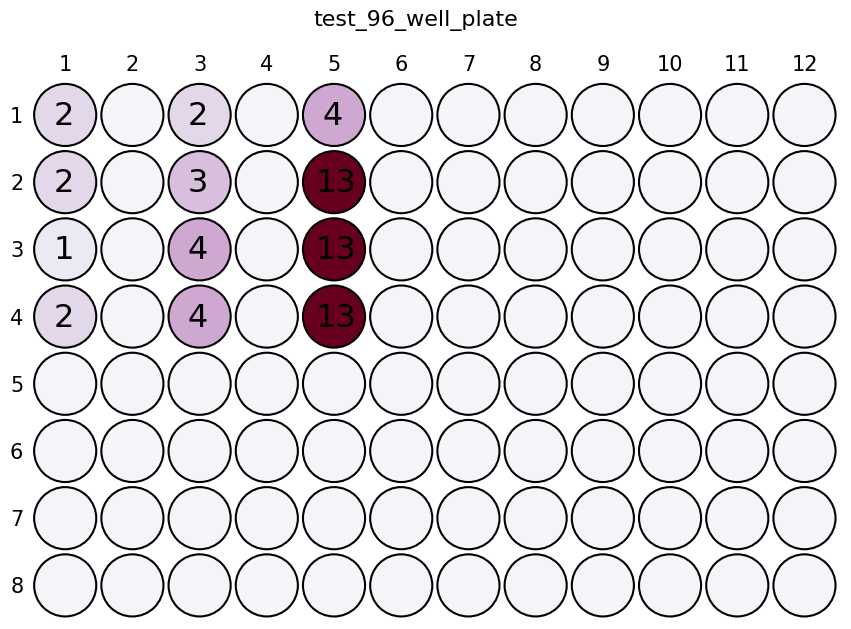

In [ ]:
plot_96wells(cdata=final_df_int, figure=1, figure_name='test_96_well_plate', colorbar_type='PuRd')